In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.io import export_svgs
import bokeh as bk
import tensorflow as tf
output_notebook()
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
datos = pd.read_csv("./drive/My Drive/Colab Notebooks/data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [0]:
obj_rg = open("./drive/My Drive/Colab Notebooks/data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [0]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [0]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

In [0]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [0]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [0]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4168, 9)

In [0]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.15))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [0]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [0]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [0]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [0]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    kl_d = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        y_proba = D.predict_proba(X_comb)
        #kl_d.append(np.mean((1-y_proba)/y_proba))
        kl_d.append(np.mean(y_proba*np.log(y_proba/(1-y_proba))))
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall, kl_d

In [0]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 9)                 11559     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


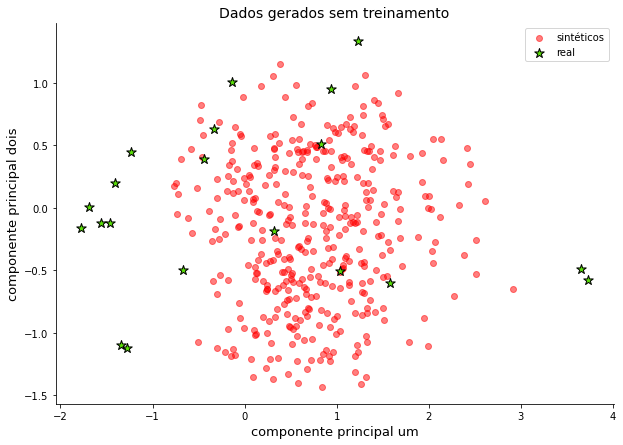

In [0]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
g_loss, d_loss, precision, recall, kld = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
epoch:[1/1700] [Discriminator::d_loss: 0.743062],[Generator::loss: 0.666070], 1.022740[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.729001],[Generator::loss: 0.689769], 0.265762[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.734806],[Generator::loss: 0.681545], 0.148529[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.759997],[Generator::loss: 0.692694], 0.136592[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.749624],[Generator::loss: 0.676840], 0.121271[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.720705],[Generator::loss: 0.709272], 0.122151[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.742224],

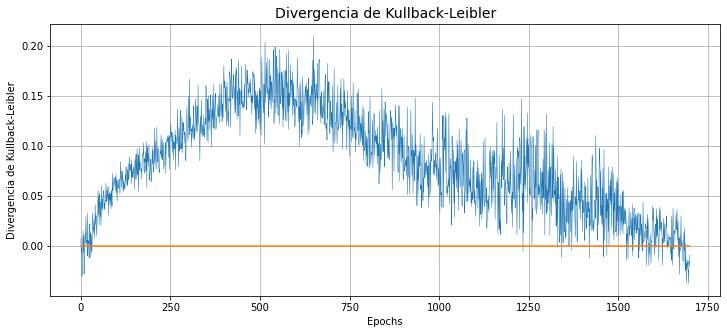

In [0]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(kld)), kld, linewidth=.5)
plt.plot(range(len(kld)), np.zeros(len(kld)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

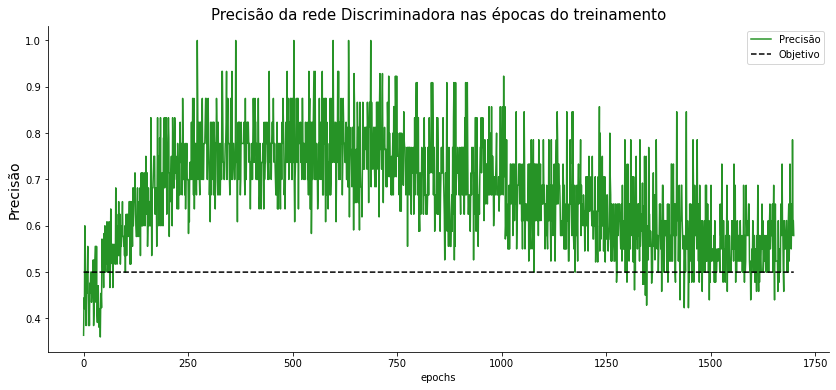

In [0]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

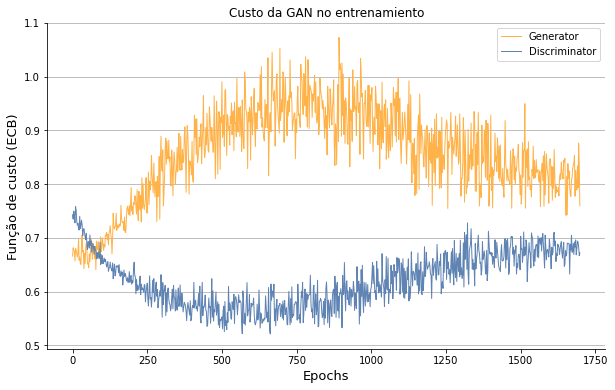

In [0]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 2)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.title("Custo da GAN no entrenamiento")
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248", linewidth=1)
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4", linewidth=1)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Função de custo (ECB)", fontsize=13)
plt.grid(axis="y")
plt.legend();

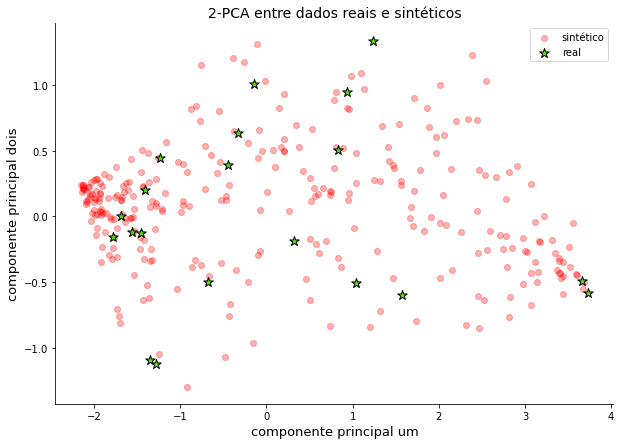

In [0]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
min_pre = np.inf
dict_weights = {}
l_dist = []
for i in range(100):
    t_i = time()
    G = obj_G.compileG()
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    w_i = gan.get_weights().copy()
    g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(30):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        #y_proba = D.predict_proba(X_gen)
        y_predict = D.predict_classes(X_gen)
        d = []
        for g in range(X_train.shape[0]):
            #print(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
            #print(abs(1-np.mean((1-y_proba)/y_proba)))
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d))+ 1.5*abs(0.5 - np.mean(y_predict)))

    w_f = gan.get_weights().copy()
    l_dist.append(np.mean(np.array(l_pre)))
    dict_weights[np.mean(np.array(l_pre))] = [i, l_dist[-1], w_i, w_f]
    if l_dist[-1] < min_pre:
        min_pre = l_dist[-1]
        w_best = w_f
    t_f = time()
    print("iteração[",i,"] : erro:",l_dist[i],"tempo:", np.round(t_f-t_i,4), "[s]")

In [0]:
 np.save("./drive/My Drive/Colab Notebooks/data/dictionary_weights", dict_weights)

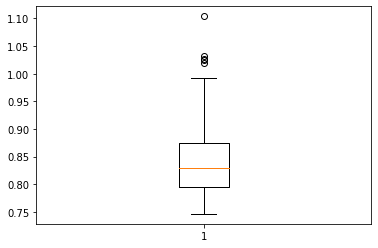

In [0]:
plt.boxplot(l_dist);

## Results and plots

In [0]:
weights = np.load("./drive/My Drive/Colab Notebooks/data/dictionary_weights.npy", allow_pickle=True).item()

In [0]:
type(weights)

dict

0.746382147985137


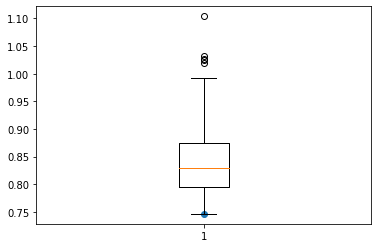

In [0]:
similarity = []
best_s = np.inf
for key in weights.keys():
  similarity.append(weights[key][1])
  if weights[key][1] < best_s:
    best_s = weights[key][1]
    best_initial_weights = weights[key][2]
similarity = np.array(similarity)
plt.boxplot(similarity);
plt.scatter(1, min(similarity));
print(best_s)

In [0]:
def boxplot_params(x):
  """
  This function retunrs necessary parameters to plot
  a boxplot with bokeh
  """
  q25 = np.quantile(x, .25, interpolation="midpoint")
  q50 = np.quantile(x, .5, interpolation="midpoint")
  q75 = np.quantile(x, .75, interpolation="midpoint")
  IQR = q75 - q25
  lower = q25 - 1.5*IQR
  upper = q75 + 1.5*IQR
  outliers = x[[x<lower]and[x>upper]]

  return lower, q25, q50, q75, upper, outliers

In [0]:
lower, q25, q50, q75, upper, outliers = boxplot_params(similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


In [0]:
p = figure(tools="", toolbar_location=None, width=220, height= 250, x_range=[0,2])

p.segment(1, lower, 1, q25, line_color="black")
p.segment(1, upper, 1, q75, line_color="black")
p.rect(1, lower, width=.3, height=.0005, line_color="black")
p.rect(1, upper, width=.3, height=.0005, line_color="black")
p.vbar(1, 0.7, q75, q50, fill_color="#E08E79", line_color="black")
p.vbar(1, 0.7, q50, q25, fill_color="#3B8686", line_color="black")
p.circle(1, outliers, size=7, color="#F38630", fill_alpha=0.6, legend_label="Piores pesos")
#best_case
p.circle(1, min(similarity), size=7, color="green", fill_alpha=0.6, legend_label="Melhores pesos")
p.xgrid.grid_line_color = None
p.yaxis.axis_label= "Similaridade (S)"
#p.xaxis.visible = False
p.xaxis.ticker = [1]
#p.xaxis.axis_line_color = "red"
p.output_backend = "svg"
#export_svgs(p, "./drive/My Drive/Colab Notebooks/data/images/boxplot_weights.svg")
show(p)
np.save("./drive/My Drive/Colab Notebooks/data/similarity", similarity)

In [0]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [0]:
similarity = np.sort(similarity)

In [0]:
gan.set_weights(weights[similarity[1]][2])

In [0]:
#np.save("./drive/My Drive/Colab Notebooks/data/qualification_precision_gan", precision)
#np.save("./drive/My Drive/Colab Notebooks/data/qualification_g_loss_gan", g_loss)
#np.save("./drive/My Drive/Colab Notebooks/data/qualification_d_loss_gan", d_loss)
#np.save("./drive/My Drive/Colab Notebooks/data/qualification_recall_gan", recall)
#np.save("./drive/My Drive/Colab Notebooks/data/qualification_KLD_gan", kld)
#gan.save("./drive/My Drive/Colab Notebooks/data/qualification_gan_model.h5")

In [0]:
precision = np.load("./drive/My Drive/Colab Notebooks/data/qualification_precision_gan.npy")
g_loss = np.load("./drive/My Drive/Colab Notebooks/data/qualification_g_loss_gan.npy")
d_loss = np.load("./drive/My Drive/Colab Notebooks/data/qualification_d_loss_gan.npy")
recall = np.load("./drive/My Drive/Colab Notebooks/data/qualification_recall_gan.npy")
kld = np.load("./drive/My Drive/Colab Notebooks/data/qualification_KLD_gan.npy")
gan = tf.keras.models.load_model("./drive/My Drive/Colab Notebooks/data/qualification_gan_model.h5")
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [0]:
#g_loss, d_loss, precision, recall, kld = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
#                                          gan=gan, noise_input=noise_input)

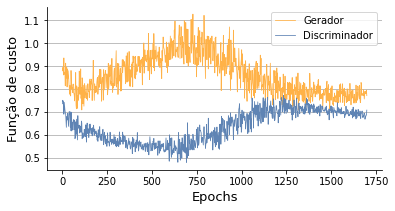

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 2)
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Gerador", color="#FFB248", linewidth=.8)
plt.plot(rr, short_d_loss, label="Discriminador", color="#5F84B4", linewidth=.8)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Função de custo", fontsize=13)
plt.grid(axis="y")
plt.legend(loc="upper right");
plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_cost_function.svg")

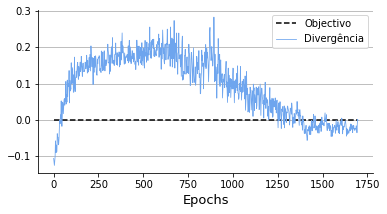

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(kld), 2)
short_kld = [kld[i] for i in rr]
plt.plot(rr,np.zeros(len(rr)), color="black", ls="--", label="Objectivo");
plt.plot(rr, short_kld, linewidth=.8, color="#6EA5EE", label="Divergência");
plt.xlabel("Epochs", fontsize=13)
#plt.ylabel("D_{kl}", fontsize=13)
plt.grid(axis="y")
plt.legend()
plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_KLD.svg")

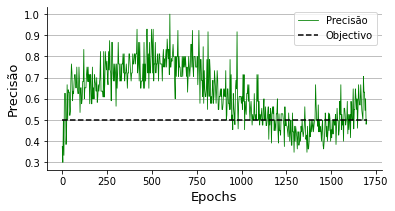

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
plt.plot(rr, short_precision, linewidth=.8, color="green", label="Precisão");
plt.ylabel("Precisão", fontsize=13)
plt.xlabel("Epochs", fontsize=13)
plt.plot(rr,np.ones(len(short_precision))*.5, color="black", ls="--", label="Objectivo");
plt.legend();
plt.grid(axis="y")
plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_precision.svg");

In [0]:
G.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 150)               7650      
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape_1 (Reshape)          (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [0]:
pesos_g = []
for i in range(len(G.get_weights())):
  pesos_g.append(gan.get_weights()[i])
G.set_weights(pesos_g)  

In [0]:
pesos_d = []
for i in range(len(D.get_weights())):
  pesos_d.append(gan.get_weights()[6+i])
D.set_weights(pesos_d)

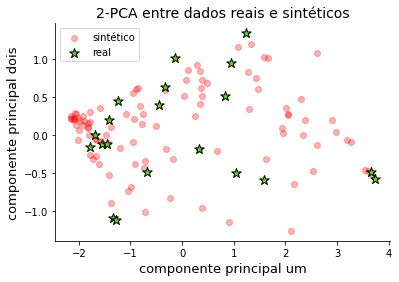

In [0]:
X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0]*5, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
from sklearn.svm import OneClassSVM

nu_val = 0.0138
clf = OneClassSVM(kernel="rbf", nu=nu_val, gamma="auto").fit(X_train[:14])

print("train accuracy: ", recall_score(clf.predict(X_train[:14]), np.ones(X_train[:14].shape[0])))
print("test accuracy: ", recall_score(clf.predict(X_train[14:]), np.ones(X_train[14:].shape[0])))

values = np.linspace(0.01, 0.2, 300)
best_score = -np.inf
for i in values:
  clf = OneClassSVM(kernel="rbf", nu=i, gamma="auto").fit(X_train[:14])
  train_s = recall_score(clf.predict(X_train[:14]), np.ones(X_train[:14].shape[0]))
  test_s = recall_score(clf.predict(X_train[14:]), np.ones(X_train[14:].shape[0]))
  if (train_s + test_s)*.5 > best_score:
    best_score = (train_s + test_s)*.5
    best_nu = i

print(best_score)
print(best_nu)
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
print(cand.shape)
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)

obj_rg = open("./drive/My Drive/Colab Notebooks/data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)
print(cand.loc[cand.index.intersection(rg_moose)].shape[0])
obj.inverse_transform(cand.loc[cand.index.intersection(rg_moose)])

fig2 = plt.figure(figsize=(7,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidates");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Reference genes", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
def best_sample(generator, discriminator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        y_proba = D.predict_proba(x_pred)
        #coefficient of variation
        cv = np.median(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1)) + np.mean((1-y_proba)/y_proba)
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

t_i = time()
dt_cv, best_idx = best_sample(G, D, X_train.shape[0]*5, 1000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i)/60, "[min]")
print(dt_cv[best_idx][0], best_idx)

tempo de execuçฺão:  1.0109527349472045 [min]
1.139488998447621 47


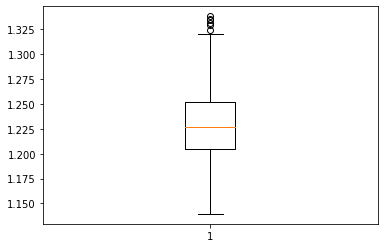

In [0]:
e_values = []
for k in dt_cv.keys():
  e_values.append(dt_cv[k][0])

plt.boxplot(e_values);

In [0]:
X_nov = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
#X_nov = np.concatenate((X_train[:14], best_value[sorted(best_value.keys())[0]]))
X_nov.shape

(114, 9)

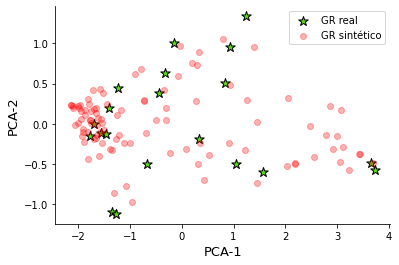

In [0]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1", fontsize=13)
plt.ylabel("PCA-2", fontsize=13)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="GR real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="GR sintético", alpha=0.3)
plt.legend();
plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_best_genes.svg");

In [0]:
best_score = -np.inf

for nu in np.linspace(0.01, 0.1, 200):
    clf = OneClassSVM(kernel="rbf", nu=nu, gamma="auto").fit(X_nov)
    recall_train_all = recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov))
    recall_train_rg = recall_score(np.ones(X_train[:14].shape[0]), clf.predict(X_train[:14]))
    test_accuracy = recall_score(np.ones(X_train[14:].shape[0]), clf.predict(X_train[14:]))
    if (recall_train_all + test_accuracy)*.5 + recall_train_rg > best_score:
      best_nu = nu
      best_score = (recall_train_all + test_accuracy)*.5 + recall_train_rg

print(best_nu)
print(best_score)

0.01678391959798995
1.8320802005012533


train accuracy in the augmented data:  0.9736842105263158
train accuracy in the RG:  0.9285714285714286
test accuracy in the RG:  0.8333333333333334
accuray em todos os genes de referência:  0.9
accuracy de solo datos sintéticos:  0.9273333333333333
(753, 9)


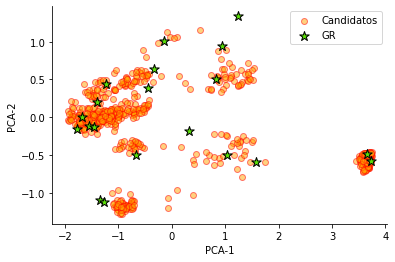

In [0]:
from sklearn.svm import OneClassSVM
#nu=0.01678
nu_val = 0.01678391959798995
clf = OneClassSVM(kernel="rbf", nu=nu_val, gamma="auto").fit(X_nov) #0.0138

print("train accuracy in the augmented data: ", accuracy_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", accuracy_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", accuracy_score(np.ones(6),clf.predict(X_train[14:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("accuracy de solo datos sintéticos: ", recall_score(np.ones(3000),
                                                          clf.predict(G.predict(np.random.normal(0, 1, (3000, noise_input))))))
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)
print(cand.shape)
cand.to_csv("./drive/My Drive/Colab Notebooks/data/qualification_candidates.csv", index=True)
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidatos");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="GR", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();
plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_candidates.svg");

In [0]:
obj_rg = open("./drive/My Drive/Colab Notebooks/data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)
print(cand.loc[cand.index.intersection(rg_moose)].shape[0])
obj.inverse_transform(cand.loc[cand.index.intersection(rg_moose)])

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']
11


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
ftsX,17.283468,17.211118,17.704248,17.548220,17.468362,17.183374,17.312165,17.172730,17.229119
ftsY,17.550514,17.735708,18.264594,8.156589,17.947226,17.553659,17.694997,17.020047,17.620549
glyY,14.753671,14.984036,15.782248,15.936056,15.625809,14.684184,14.648358,12.727299,14.368036
mutY,17.373103,17.528446,17.745346,17.812510,7.883560,17.317890,17.373409,16.924731,17.420487
ndk,10.603663,10.976263,11.795528,12.046953,11.885098,11.317893,11.674479,19.749277,10.758506
nfuA,18.720739,18.881042,19.617390,19.546358,19.448915,18.472734,18.845986,17.694977,18.563178
rrsE,16.545805,16.843786,17.556910,17.965429,17.851023,17.265075,16.883443,15.089248,16.812704
rrsG,10.199734,10.527819,11.164486,11.511491,11.492664,10.876762,10.110066,18.236019,10.107531
spoT,18.574187,18.780831,19.288445,18.885756,18.810361,18.290208,18.384982,17.670559,18.479646
thrW,11.172821,11.574243,11.968120,12.644266,12.282121,11.556343,11.851214,19.815133,10.915820


In [0]:
1 - cand.shape[0]/X_cand.shape[0]

0.819337811900192

(775, 9)


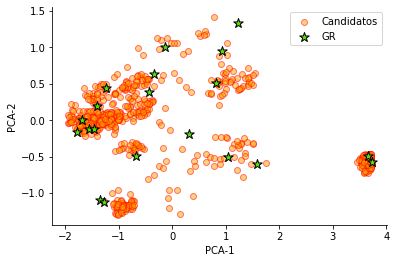

In [0]:
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
print(cand.shape)
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidatos");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="GR", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();
#plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_candidatos.svg");

In [0]:
from sklearn.svm import OneClassSVM
percentages = np.arange(start=0., stop = 17.25, step=.25)
d_per = {}
for p in percentages:
  tic = time()
  dt_cv, best_idx = best_sample(G, D, int(p*X_train.shape[0]), 1000, noise_input)
  X_augmented = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
  best_score = -np.inf
  for nu in np.linspace(0.01, 0.2, 300):
    clf = OneClassSVM(kernel="rbf", nu=nu, gamma="auto").fit(X_augmented)
    recall_train_all = recall_score(np.ones(X_augmented.shape[0]), clf.predict(X_augmented))
    recall_train_rg = recall_score(np.ones(X_train[:14].shape[0]), clf.predict(X_train[:14]))
    test_accuracy = recall_score(np.ones(X_train[14:].shape[0]), clf.predict(X_train[14:]))
    if (recall_train_all + test_accuracy)*.5 + recall_train_rg > best_score:
      best_nu = nu
      best_score = (recall_train_all + test_accuracy)*.5 + recall_train_rg
  clf = OneClassSVM(kernel="rbf", nu=best_nu, gamma="auto").fit(X_augmented)
  train_accuracy = accuracy_score(np.ones(X_augmented.shape[0]), clf.predict(X_augmented))
  test_accuracy = accuracy_score(np.ones(X_train[14:].shape[0]), clf.predict(X_train[14:]))
  d_per[p] = [dt_cv[best_idx][0], dt_cv[best_idx][1], best_nu, train_accuracy, test_accuracy]
  toc = time()
  #print("[%f/%d] | time: %f [min]"%(p, len(percentages), (toc-tic)/60))
  print("[{}/{}] | time: {} [min]".format(p, len(percentages), (toc-tic)/60))

[0.25/68] | time: 0.9869611938794454 [min]
[0.5/68] | time: 0.9858043154080709 [min]
[0.75/68] | time: 0.9828185002009074 [min]
[1.0/68] | time: 0.977005668481191 [min]
[1.25/68] | time: 1.0401975154876708 [min]
[1.5/68] | time: 0.9829164187113444 [min]
[1.75/68] | time: 0.9995237668355306 [min]
[2.0/68] | time: 0.9926706393559773 [min]
[2.25/68] | time: 0.9894117474555969 [min]
[2.5/68] | time: 0.9665770252545675 [min]
[2.75/68] | time: 1.0010666410128275 [min]
[3.0/68] | time: 1.0098633885383606 [min]
[3.25/68] | time: 1.055600603421529 [min]
[3.5/68] | time: 1.0239604632059733 [min]
[3.75/68] | time: 1.0941844503084819 [min]
[4.0/68] | time: 1.037998112042745 [min]
[4.25/68] | time: 1.0335238258043924 [min]
[4.5/68] | time: 1.0254495859146118 [min]
[4.75/68] | time: 1.0262643694877625 [min]
[5.0/68] | time: 1.0422350804011027 [min]
[5.25/68] | time: 1.0408032894134522 [min]
[5.5/68] | time: 1.0449308276176452 [min]
[5.75/68] | time: 1.0446758627891541 [min]
[6.0/68] | time: 1.035223

In [0]:
#np.save("./drive/My Drive/Colab Notebooks/data/percentages_dictionary", d_per)
d_per = np.load("./drive/My Drive/Colab Notebooks/data/percentages_dictionary.npy", allow_pickle=True).item()

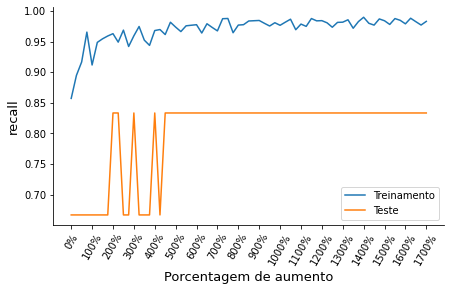

In [0]:
percentages = np.arange(start=0., stop = 17.25, step=.25)
x_plot = sorted(d_per.keys())
train_score = [d_per[k][3] for k in x_plot]
test_score = [d_per[k][4] for k in x_plot]
fig2 = plt.figure(figsize=(7,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.plot(percentages, train_score, label="Treinamento")
plt.plot(percentages, test_score, label="Teste")
plt.xticks(range(0,18,1),[str(i)+"%" for i in range(0,1800,100)], rotation=60)
plt.ylabel("recall", fontsize=13)
plt.xlabel("Porcentagem de aumento", fontsize=13)
#plt.grid()
plt.legend();
plt.savefig("./drive/My Drive/Colab Notebooks/data/images/qualification_recalls.svg");

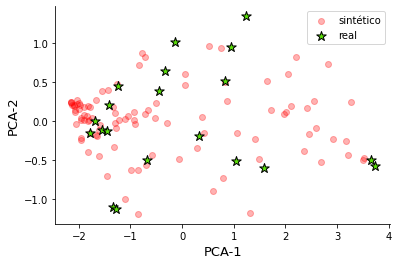

In [0]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1", fontsize=13)
plt.ylabel("PCA-2", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="GR sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="GR real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
X_augmented = np.concatenate
nu_val = 0.01
clf = OneClassSVM(kernel="rbf", nu=nu_val, gamma="auto").fit(X_train[:14]) #0.0138

print("train accuracy: ", recall_score(clf.predict(X_train[:14]), np.ones(X_train[:14].shape[0])))
print("test accuracy: ", recall_score(clf.predict(X_train[14:]), np.ones(X_train[14:].shape[0])))

values = np.linspace(0.01, 0.2, 300)
best_score = -np.inf
for i in values:
  clf = OneClassSVM(kernel="rbf", nu=i, gamma="auto").fit(X_train[:14]) #0.0138
  train_s = recall_score(clf.predict(X_train[:14]), np.ones(X_train[:14].shape[0]))
  test_s = recall_score(clf.predict(X_train[14:]), np.ones(X_train[14:].shape[0]))
  if (train_s + test_s)*.5 > best_score:
    best_score = (train_s + test_s)*.5
    best_nu = i

print(best_score)
print(best_nu)
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
print(cand.shape)
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)

obj_rg = open("./drive/My Drive/Colab Notebooks/data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)
print(cand.loc[cand.index.intersection(rg_moose)].shape[0])
obj.inverse_transform(cand.loc[cand.index.intersection(rg_moose)])

fig2 = plt.figure(figsize=(7,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidates");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Reference genes", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();